# <b>DS3000 Group Project</b>

# <b>Chef.AI</b> - Lukas Bozinov & Arjun Atwal - Group 31

## Section 0 - Preliminary Code

### Section 0.1: Import all necessary libraries

In [99]:
import numpy as np #etc etc etc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv, ast, math

### Section 0.2: Other things

In [100]:
print('balls in 3D')

balls in 3D


## Section 1 - Organization of Dataset

### Section 1.1: Parse the dataset
Formatting data into a format that is easily passed to math functions.

In [101]:
# written by lukas (i am the goat)

class Food:
    def __init__(self, food_name, food_group, colour_day, mass_day, temp_day):
        self.food_name = food_name
        self.food_group = food_group
        self.colour_day = colour_day
        self.mass_day = mass_day
        self.temp_day = temp_day

    def __str__(self):
        return (
            f"Food Name: {self.food_name}\n"
            f"Food Group: {self.food_group}\n"
            f"Colour (RGB) by Day: {self.colour_day}\n"
            f"Mass (grams) by Day: {self.mass_day}\n"
            f"Temperature (degrees C) by Day: {self.temp_day}\n"
        )

foodList = []

with open('ourData.csv', "r") as commentedFile: 
    reader = csv.reader(commentedFile)
    next(reader)  # skip line of headers

    for row in reader:
        food_name = row[0].strip()
        food_group = row[1].strip()
        colour_day_raw = row[2].strip()
        mass_day_raw = row[3].strip()
        temp_day_raw = row[4].strip()

        colour_day_list = ast.literal_eval(colour_day_raw)
        mass_day_list = ast.literal_eval(mass_day_raw)
        temp_day_list = ast.literal_eval(temp_day_raw)

        # Use lists instead of dictionaries because duplicate values erases entries that we need
        colour_day = colour_day_list
        mass_day = mass_day_list
        temp_day = temp_day_list

        food = Food(food_name, food_group, colour_day, mass_day, temp_day)

        foodList.append(food)

# get total number of days for later processing
numDays = len(foodList[0].colour_day)



### Section 1.2: Data Pre-Processing
Passing Data to math functions to create mass factors

In [102]:
# import deez

def freshness_index(time, mass_initial, mass_curr, temp_curr, temp_optimal, color_curr, color_optimal, weight_mass = 0.5, weight_temp = 0.3, weight_color = 0.2, alpha = 0.3, sigma = 5, lambda_ = 0.05):

    # Mass Factor - not certain about this
    mass_factor = (math.exp(-alpha * time * (mass_curr / mass_initial))) * weight_mass
    # print(mass_factor)

    # Temperature Factor
    temp_factor = math.exp(-((temp_curr - temp_optimal) ** 2) / (2 * sigma ** 2)) * weight_temp
    # print(temp_factor)

    # Color Factor - asm color_curr, color_optimal are in range RGB(0-255, 0-255, 0-255)
    color_diff = math.sqrt((color_curr[0] - color_optimal[0]) ** 2 + (color_curr[1] - color_optimal[1]) ** 2 + (color_curr[2] - color_optimal[2]) ** 2)
    color_factor = math.exp(-lambda_ * color_diff) * weight_color
    # print(color_factor)

    # Freshness Index
    freshness_index = mass_factor + temp_factor + color_factor
    return min(1, freshness_index) # with the weights summing to 1, the maximum value of the freshness index is 1


# initialize optimal values for the freshness_index function
color_optimal = (foodList[0].colour_day[0][0])
temp_optimal = foodList[0].temp_day[0][0]
mass_initial = foodList[0].mass_day[0][0]

days = []
for i in range(numDays):
    days.append(i)

    #freshness_values = np.array([1.0, 0.710923868536591, 0.63709970475181, 0.511606076772564, 0.44434784966860497, 0.40576335646495826, 0.381205757697219])

days = np.array(days)

freshness_values = []

for i in range(numDays):
    color_curr = (foodList[0].colour_day[i][0])
    temp_curr = foodList[0].temp_day[i][0]
    mass_curr = foodList[0].mass_day[i][0]
    time = i

    # print(color_curr)
    # print(temp_curr)
    # print(mass_curr)
    # print(time)
    print('Time =', time)
    freshnessindex = freshness_index(time, mass_initial, mass_curr, temp_curr, temp_optimal, color_curr, color_optimal)
    print(freshnessindex)
    freshness_values.append(freshnessindex)

freshness_values = np.array(freshness_values)

print(days)
print(freshness_values)



Time = 0
1
Time = 1
0.710923868536591
Time = 2
0.63709970475181
Time = 3
0.511606076772564
Time = 4
0.44434784966860497
Time = 5
0.40576335646495826
Time = 6
0.381205757697219
[0 1 2 3 4 5 6]
[1.         0.71092387 0.6370997  0.51160608 0.44434785 0.40576336
 0.38120576]


## Section 2 - Mathematical Function Initialization

### Section 2.1: Sigmoid Function Declaration

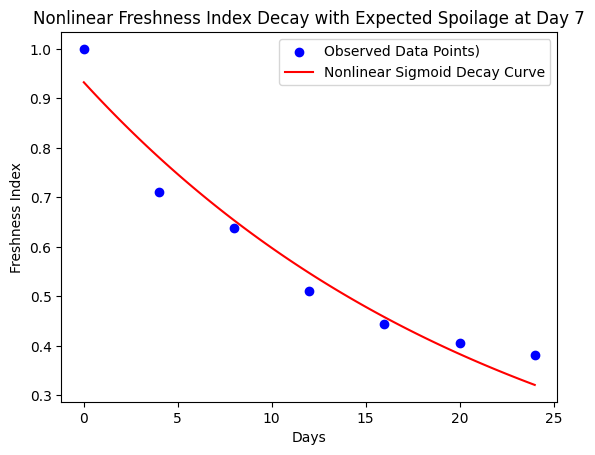

In [ ]:
# Define the sigmoid decay model function
def freshness_sigmoid_model(t, L, k, t_0):
    return L / (1 + np.exp(-k * (t - t_0)))

days = days*4 # why the hell do i have to multiply by 4 to get no overflow?
#no seriously man wtf

# Provide initial parameter guesses and increase maxfev
initial_guesses = [1, 1, 12]  # Starting guesses for L, k, and t_0, L controls the maximum freshness value, k controls the steepness of the curve, and t_0 controls the midpoint of the curve.
params, covariance = curve_fit(
    freshness_sigmoid_model, 
    days, 
    freshness_values, 
    p0=initial_guesses, 
    maxfev=5000
)

# Extract fitted parameters
L, k, t_0 = params

# Predict freshness values for all days up to Day 5
days_extended = np.linspace(0, 24, 100)  # Use a smoother range for better curve
predicted_freshness = freshness_sigmoid_model(days_extended, L, k, t_0)

# Plot the observed data and the fitted sigmoid curve
plt.scatter(days, freshness_values, color='blue', label='Observed Data Points)')
plt.plot(days_extended, predicted_freshness, color='red', label='Nonlinear Sigmoid Decay Curve')
plt.xlabel('Days')
plt.ylabel('Freshness Index')
plt.title('Nonlinear Freshness Index Decay with Expected Spoilage at Day 7')
plt.legend()
plt.show()

### Section 2.2: Other Mathematical Functions

In [104]:
print('more math')

more math


## Section 3 - Modelling

### Section 3.1: Load data into model

In [105]:
print('LOAD IT MAN')

LOAD IT MAN


### Section 3.2: Fit model

In [106]:
print('model.fit go brrrrr')

model.fit go brrrrr


### Section 3.3: Evaluate accuracy

In [107]:
print('auroc man idk')

auroc man idk


## Section 4 - Visualization

### Section 4.1: Line graph

In [108]:
print('something something matplotlib')

something something matplotlib


### Section 4.2: Other visualization

In [109]:
print('something something seaborn')

something something seaborn


## Section 5 - Comparisons to other models (?)

### Section 5.1: Comparison to linear regression

In [110]:
print('news flash: linear regression sucks')

news flash: linear regression sucks


## Section 6 - Conclusions to draw

In [111]:
print('overall, our model is better than the other one')

overall, our model is better than the other one
